In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [41]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\MumbaiCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,01-01-2019 00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01-01-2019 01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01-01-2019 02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-01-2019 03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-01-2019 04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43819,31-12-2023 19:00,36.453333,30.333333,29.490000,77.9,0.1450,260.7450,NaN,1011.2050,NaN,26.6525
43820,31-12-2023 20:00,41.647500,30.370000,40.027500,77.9,0.1350,262.8250,NaN,1011.9075,NaN,25.5975
43821,31-12-2023 21:00,58.050000,30.092500,50.552500,77.9,0.1350,264.1175,NaN,1012.3650,NaN,24.8025
43822,31-12-2023 22:00,NaN,30.623333,49.326667,77.9,0.1400,263.9175,NaN,1012.6775,NaN,24.0700


In [42]:
data = data.drop(columns=[ 'From Date'])

In [43]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [44]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [45]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [46]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [47]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [48]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [50]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [51]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
1096/1096 [==============================] - 37s 16ms/step - loss: 1285.1973 - val_loss: 831.4758
Epoch 2/100
1096/1096 [==============================] - 14s 13ms/step - loss: 646.4208 - val_loss: 670.9988
Epoch 3/100
1096/1096 [==============================] - 14s 13ms/step - loss: 575.4629 - val_loss: 639.0643
Epoch 4/100
1096/1096 [==============================] - 13s 12ms/step - loss: 547.4156 - val_loss: 601.6517
Epoch 5/100
1096/1096 [==============================] - 13s 12ms/step - loss: 529.0174 - val_loss: 593.3283
Epoch 6/100
1096/1096 [==============================] - 12s 11ms/step - loss: 516.6363 - val_loss: 573.1706
Epoch 7/100
1096/1096 [==============================] - 13s 12ms/step - loss: 508.8290 - val_loss: 564.6945
Epoch 8/100
1096/1096 [==============================] - 14s 13ms/step - loss: 501.3938 - val_loss: 561.4119
Epoch 9/100
1096/1096 [==============================] - 14s 13ms/step - loss: 495.8787 - val_loss: 553.6755
Epoch 10/100
1096/

In [52]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

274/274 [==============================] - 1s 4ms/step - loss: 470.8727
Test Loss: 470.8726806640625
274/274 [==============================] - 3s 3ms/step


In [53]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9308491212052042
Root Mean Square Error (RMSE): 21.699601155406857
Correlation Coefficient (r): 0.84366804190417
Mean Gross Error (MGE): 12.527852912240865
Mean Bias (MB): 1.1694649839357378
Coefficient of Efficiency (COE): 0.7108132787589807
Coefficient of Determination (R2 score): 0.7095322394457483


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats


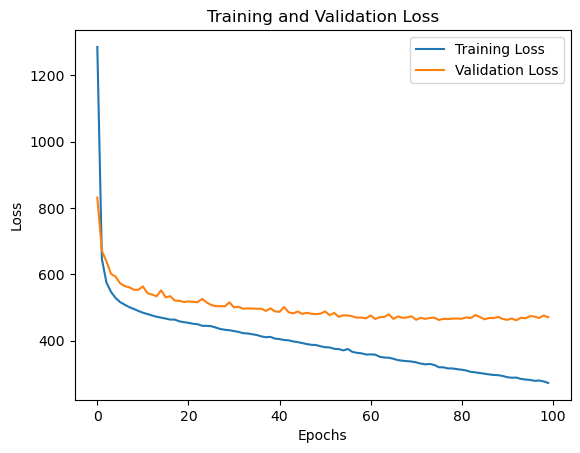

In [55]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


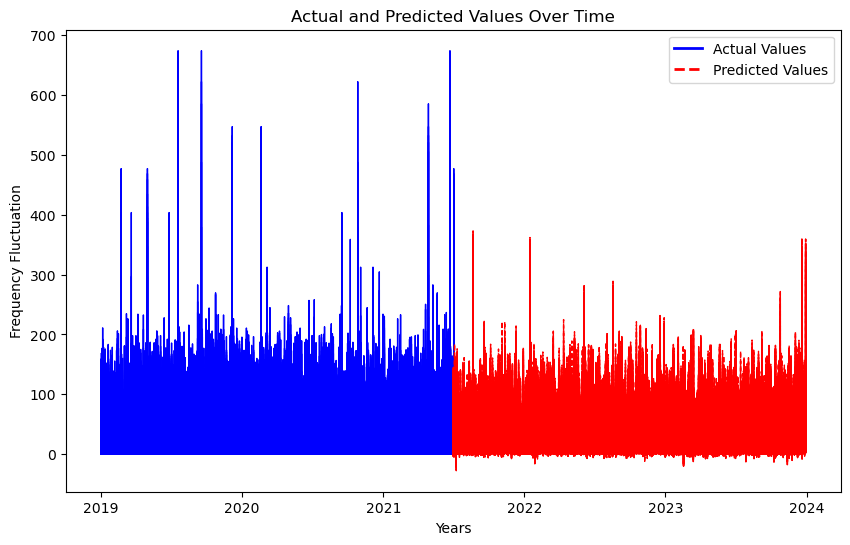

In [68]:
# Line plot of actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(y_test)), y_test, label='Actual Values', color='blue', linewidth=1)
plt.plot(range(len(y_test)-20, len(y_test)+len(predictions)-20), predictions, label='Predicted Values', color='red', linestyle='--', linewidth=1)
plt.title('Actual and Predicted Values Over Time')

# Adjusting x-axis to represent years
plt.xlabel('Years')
plt.ylabel('Frequency Fluctuation')

# Assuming y_test covers 80 data points (4 years) and predictions 20 data points (1 year)
# Adjust x-ticks based on total data points
total_points = len(y_test) + len(predictions)
plt.xticks(ticks=np.linspace(0, total_points, 6), labels=['2019', '2020', '2021', '2022', '2023', '2024'])

# Create custom legend handles
actual_handle = plt.Line2D([], [], color='blue', linewidth=2, label='Actual Values')
predicted_handle = plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Predicted Values')

# Add the legend with custom handles
plt.legend(handles=[actual_handle, predicted_handle])
plt.show()

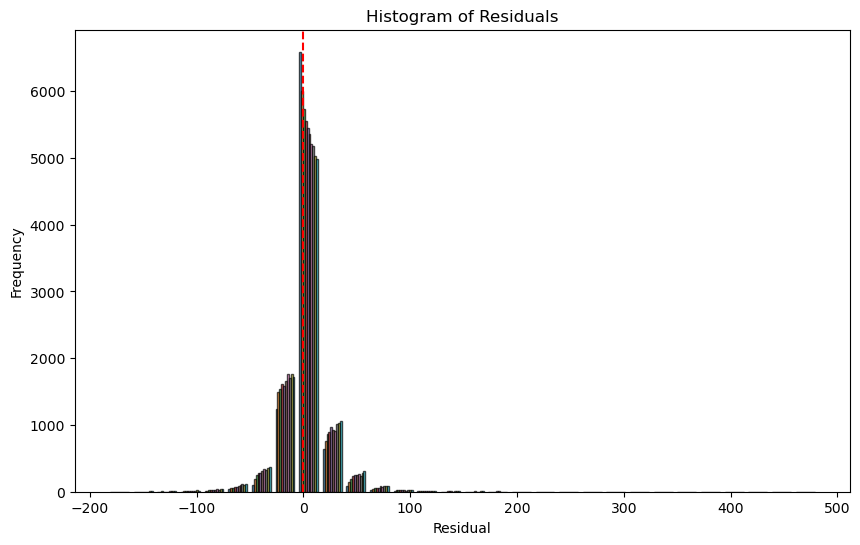

In [67]:

# Plotting the histogram of residuals
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()
